<div class="alert alert-info">
  <h1>Pattern Recognition</h1>
  <h3><font color="red">Transformers for Pattern Recognition (HW3)</font></h3>
  <h5>Teaching Assistants: </h5>

*   <a href="https://telegram.me/visionlover">Seyed Mohammad Mousavi</a>
*   <a href="https://telegram.me/Peyman_syh">Peyman attartsayah</a>


</div>

In [1]:
# @title Stdents information

first_name = 'Mohammad' # @param {type:"string", placeholder:"enter your first name"}
last_name = 'Haghighat' # @param {type:"string", placeholder:"enter your last name"}
student_number = '403722042' # @param {type:"string", placeholder:"enter your student_numbe"}

# part a

## import libraries


In [2]:
import re
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd

## prepare dataset

fisrt download the dataset from [this link](https://projectquest.ir/Transformers_for_Pattern_Recognition/hw3.txt)

In [3]:
!wget https://projectquest.ir/Transformers_for_Pattern_Recognition/hw3.txt

--2024-12-11 11:25:32--  https://projectquest.ir/Transformers_for_Pattern_Recognition/hw3.txt
Resolving projectquest.ir (projectquest.ir)... 5.9.37.15
Connecting to projectquest.ir (projectquest.ir)|5.9.37.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3230047 (3.1M) [text/plain]
Saving to: ‘hw3.txt’

hw3.txt             100%[===================>]   3.08M  2.87MB/s    in 1.1s    

2024-12-11 11:25:34 (2.87 MB/s) - ‘hw3.txt’ saved [3230047/3230047]



now rename it to `dataset.txt`

In [4]:
!mv hw3.txt dataset.txt

then we should read the dataset

In [5]:
# read it in to inspect it
file_path = 'dataset.txt'
with open(file_path, 'r', encoding='utf-8') as f:
    text = f.read()

In [6]:
print("dataset length: ", len(text))

dataset length:  3204487



In this section, we should identify all unique Letters.

In [7]:
letters = sorted(set(char for char in text))
letters_size = len(letters)
print(''.join(letters))
print(letters_size)


 !"'()*,-./0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz﻿
79


In this section, we will perform three tasks:


1.   replace every hyphen in text with a space.
2.   define a regex pattern and use it to filter the text with the `re` library. With this pattern, you should be able to replace all characters except letters, numbers, dots, and newline characters (eg:* and !) with nothing.
3. detect lines and words in text

***Note: each line will end with a dot.***


In [8]:
text = text.replace('-', ' ')
pattern = r"[^a-zA-Z0-9.\n ]"
new_text = re.sub(pattern, '', text)
lines = new_text.split('.')
joined_lines = " ".join(lines)
total_words = joined_lines.lower().split()
words = ['.']
for word in total_words:
    if word not in words:
        words.append(word)

In [9]:
vocab_size = len(words)
print("Total no. of lines: ", len(lines))
print("Total unique words: ", len(words))

Total no. of lines:  30588
Total unique words:  17877


In this part, we create two dictionaries for mapping from words to integers and vice versa.

***Note: Here, rather than assigning a one-hot vector to each word, which can be sparse, we assign a single number to represent the word. This approach helps in better understanding the outputs.***


In [10]:
stoi = {word: index for index, word in enumerate(words)}
itos = {index: word for word, index in stoi.items()}
print(len(itos))

17877


Now, we should create encoder and decoder:


*   encoder: take a string, output a list of integers
*   decoder: take a list of integers, output a string



In [11]:
def encode(text):
    return [stoi[word] for word in text.lower().split()]

def decode(ints):
    return ' '.join([itos[index] for index in ints])

print(encode("you are a teacher"))
print(decode(encode("you are a teacher")))

[18, 7, 84, 3909]
you are a teacher


Now, we should convert our data to tensor and split it into training and validation sets.

In [12]:
encoded_data = encode(joined_lines)
data = torch.tensor(encoded_data)
print(data.shape, data.dtype)

torch.Size([565963]) torch.int64


In [13]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [14]:
train_data[50:55+1]

tensor([42, 43, 29, 44, 45, 18])

## define our task

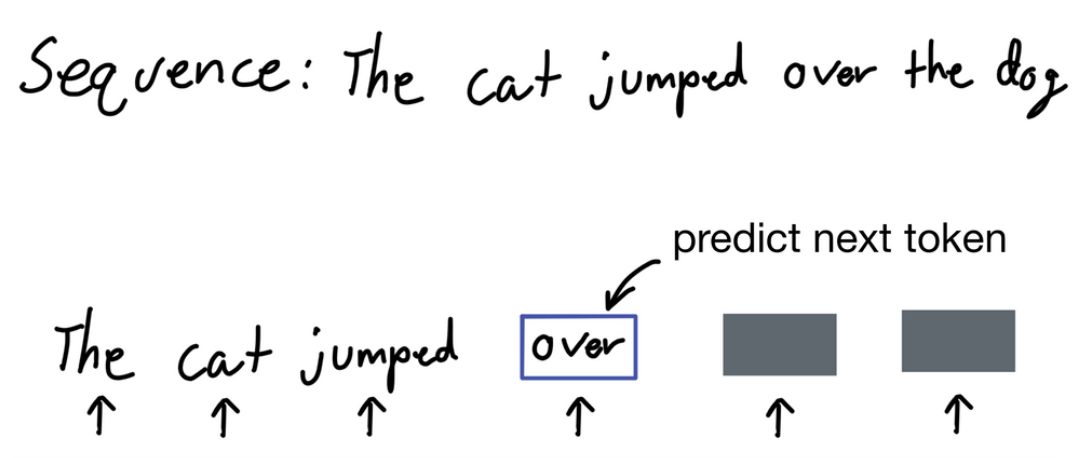

In [15]:
x = train_data[50:55]
y = train_data[51:56]
for t in range(5):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([42]) the target: 43
when input is tensor([42, 43]) the target: 29
when input is tensor([42, 43, 29]) the target: 44
when input is tensor([42, 43, 29, 44]) the target: 45
when input is tensor([42, 43, 29, 44, 45]) the target: 18


In [16]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
n_context = 8 # what is the maximum context length for predictions?
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_batch(split):
    if split == 'train':
        data = train_data
    else:
        data = val_data
    start_idx = torch.randint(0, len(data) - n_context, (batch_size,))

    x = torch.stack([data[idx:idx+n_context] for idx in start_idx]).to(device)
    y = torch.stack([data[idx+1:idx+n_context+1] for idx in start_idx]).to(device)
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(n_context): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[   34,    84,  6227,  1878,    23,    95,   558,   524],
        [  294,  2773,   855,    13, 11823,  7908,    64,    13],
        [   13,   127,    48,  3207,    15,    18,    48,   196],
        [  264,    13,  3437,    12,   198,  6989,    52,  4249]],
       device='cuda:0')
targets:
torch.Size([4, 8])
tensor([[   84,  6227,  1878,    23,    95,   558,   524,    93],
        [ 2773,   855,    13, 11823,  7908,    64,    13, 11952],
        [  127,    48,  3207,    15,    18,    48,   196,    95],
        [   13,  3437,    12,   198,  6989,    52,  4249,    52]],
       device='cuda:0')
----
when input is [34] the target: 84
when input is [34, 84] the target: 6227
when input is [34, 84, 6227] the target: 1878
when input is [34, 84, 6227, 1878] the target: 23
when input is [34, 84, 6227, 1878, 23] the target: 95
when input is [34, 84, 6227, 1878, 23, 95] the target: 558
when input is [34, 84, 6227, 1878, 23, 95, 558] the target: 524
when input is [

## self-attention review

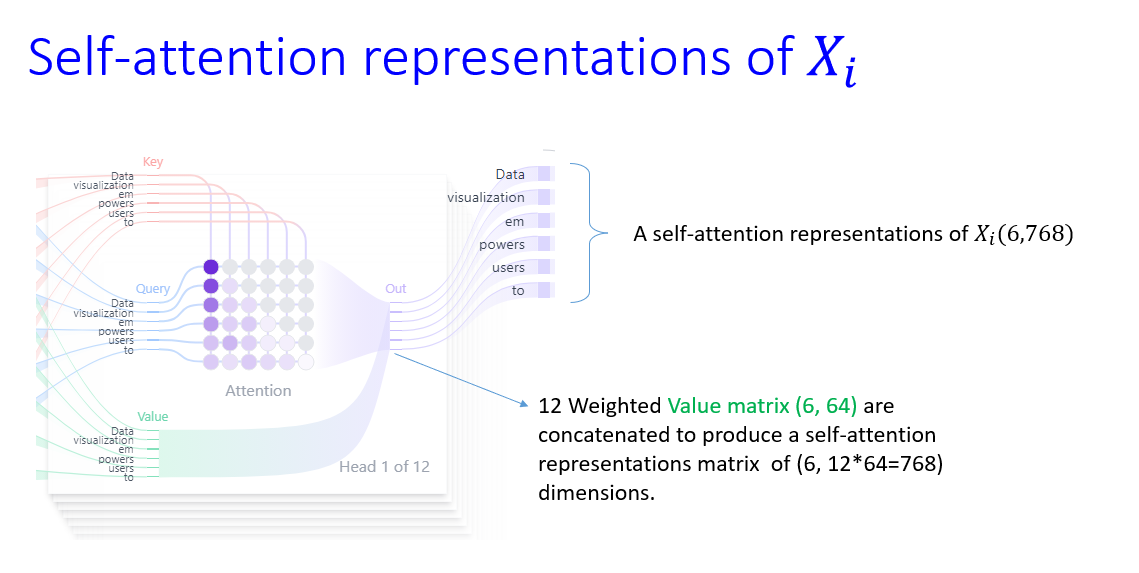

In [17]:
torch.manual_seed(1337)
batch_size, n_context, d_model = 1, 6, 768   # batch, n_context, d_model
x = torch.randn(batch_size, n_context, d_model)

print("x dimention is: ", x.shape)
# let's see a single Head perform self-attention
head_size = 64
number_of_heads = d_model//head_size

key = nn.Linear(d_model, head_size, bias=False)
query = nn.Linear(d_model, head_size, bias=False)
value = nn.Linear(d_model, head_size, bias=False)
k = key(x)
q = query(x)

print("Query dimention (Head 1 of 12) is: ", q.shape)
print("Key dimention (Head 1 of 12) is: ", k.shape)

x dimention is:  torch.Size([1, 6, 768])
Query dimention (Head 1 of 12) is:  torch.Size([1, 6, 64])
Key dimention (Head 1 of 12) is:  torch.Size([1, 6, 64])


## Mask in attention review

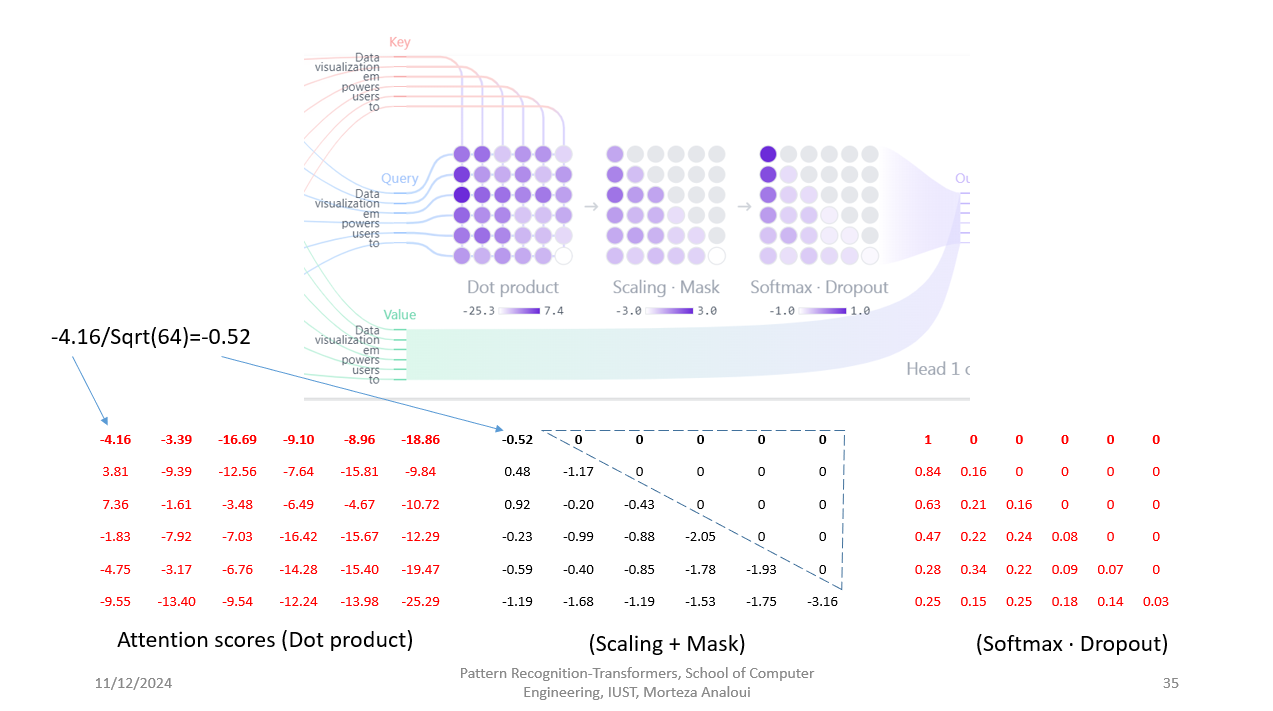

In [18]:
torch.manual_seed(1337)
batch_size, n_context, d_model = 1, 6, 768   # batch, n_context, d_model
x = torch.randn(batch_size, n_context, d_model)

print("x dimention is: ", x.shape)
# let's see a single Head perform self-attention
head_size = 64
number_of_heads = d_model // head_size

key = nn.Linear(d_model, head_size, bias=False)
query = nn.Linear(d_model, head_size, bias=False)
value = nn.Linear(d_model, head_size, bias=False)
k = key(x)
q = query(x)
wei = torch.bmm(q, k.transpose(-2, -1))
wei = wei / (head_size ** 0.5)

print("Dot product: \n", wei)
print('-'*80)
mask = torch.triu(torch.ones(n_context, n_context), diagonal=1).to(x.device)
mask = mask.masked_fill(mask == 1, float('-inf'))

# now fill mask with our attention scores

wei = wei + mask
print("(Scaling + Mask): \n", wei)
print('-'*80)

wei = F.softmax(wei, dim=-1)
print("Softmax: \n", wei)
print('-'*80)
v = value(x)
print("Value dimention (head 1 of 12) is: ", v.shape)

x dimention is:  torch.Size([1, 6, 768])
Dot product: 
 tensor([[[ 0.3276, -0.1875,  0.1882,  0.4553,  0.5395,  0.1450],
         [-0.0208, -0.0395, -0.0631,  0.3064, -0.1609, -0.0435],
         [-0.2510,  0.4182,  0.3312,  0.1494, -0.1876,  0.1770],
         [-0.2531, -0.1221, -0.2861, -0.0996, -0.2813, -0.2696],
         [-0.2068, -0.0877, -0.1030,  0.2971, -0.5337, -0.7383],
         [-0.4112,  0.1640,  0.2440,  0.0351,  0.1619, -0.3662]]],
       grad_fn=<DivBackward0>)
--------------------------------------------------------------------------------
(Scaling + Mask): 
 tensor([[[ 0.3276,    -inf,    -inf,    -inf,    -inf,    -inf],
         [-0.0208, -0.0395,    -inf,    -inf,    -inf,    -inf],
         [-0.2510,  0.4182,  0.3312,    -inf,    -inf,    -inf],
         [-0.2531, -0.1221, -0.2861, -0.0996,    -inf,    -inf],
         [-0.2068, -0.0877, -0.1030,  0.2971, -0.5337,    -inf],
         [-0.4112,  0.1640,  0.2440,  0.0351,  0.1619, -0.3662]]],
       grad_fn=<AddBackward0

## Normalization review

In [19]:
class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    variance = x.var(dim=-1, keepdim=True, unbiased=False)
    x_normalized = (x - mean) / torch.sqrt(variance + self.eps)
    self.out = self.gamma * x_normalized + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [20]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs

(tensor(0.1476), tensor(0.8847))

In [21]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

(tensor(-2.2650e-08), tensor(1.0050))

## implement transformer

Now, we implement transformer completely

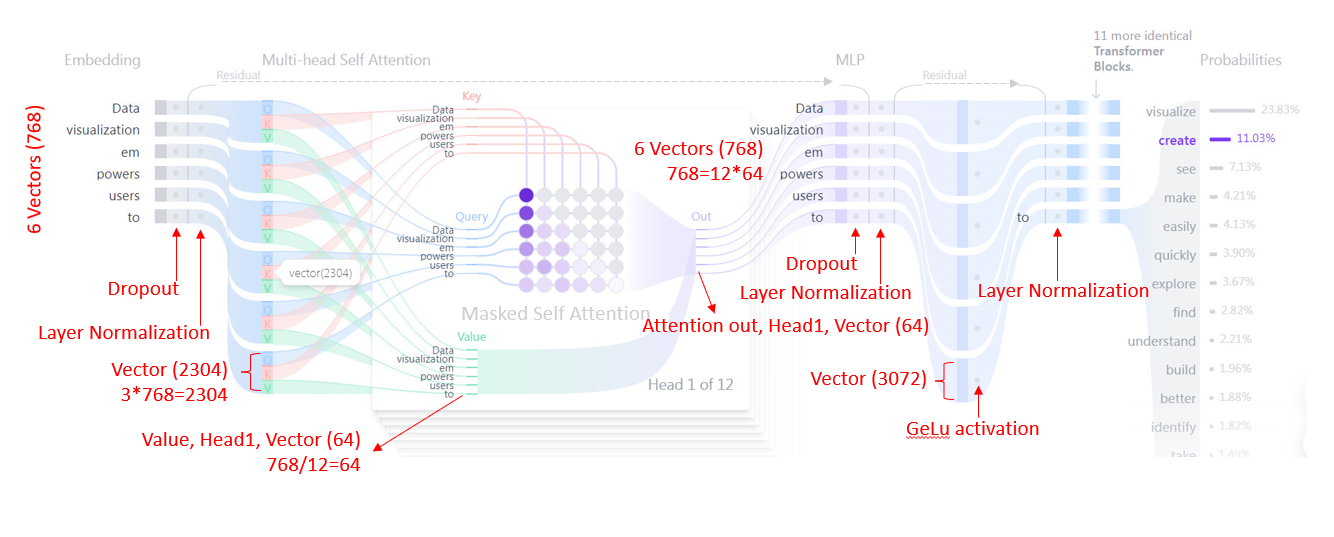

<font color="orange"><h3> Use three different Temperature hyperparameters (smaller than one - one -
Greater than one) </h3> </font>

In [22]:
# @title Temperature hyperparameter
Temperature = 1 # @param {type:"slider", min:0, max:10, step:0.1}

In [24]:
# hyperparameters
batch_size = 32 # how many independent sequences will we process in parallel?
n_context = 256 # what is the maximum context length for predictions?
max_iters = 1500
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
d_model = 768
n_head = 12
n_layer = 12
dropout = 0.0
# ------------

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(d_model, head_size, bias=False)
        self.query = nn.Linear(d_model, head_size, bias=False)
        self.value = nn.Linear(d_model, head_size, bias=False)
        self.register_buffer("mask", torch.triu(torch.ones(n_context, n_context, dtype=torch.bool), diagonal=1))
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(head_size)

    def forward(self, x):
        batch_size, n_context, d_model = x.shape
        batch_size, n_context, d_model = x.shape

        k = self.key(x)
        q = self.query(x)
        v = self.value(x)

        wei = torch.matmul(q, k.transpose(-2, -1)) / (k.shape[-1] ** 0.5)
        wei = wei.masked_fill(self.mask[:n_context, :n_context], float('-inf'))

        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = torch.matmul(wei, v)

        out = F.gelu(out)
        out = self.ln(out)
        return out


class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads * head_size, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.proj(out)
        out = self.dropout(out)
        return out

class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, d_model):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, d_model, n_head):
        super().__init__()
        head_size = d_model // n_head

        self.attn = MultiHeadAttention(n_head, head_size)
        self.ff = FeedForward(d_model)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x

# super simple bigram model
class TransformerModel(nn.Module):

    def __init__(self, temperature):
        super().__init__()
        if not isinstance(temperature, (int, float)):
            raise ValueError(f"temperature should be int or float but got {temperature}")
        self.temperature = temperature

        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(n_context, d_model)
        self.blocks = nn.Sequential(*[Block(d_model, n_head) for _ in range(n_layer)])
        self.ln = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, idx, targets=None):
        batch_size, seq_len = idx.shape
        pos = torch.arange(seq_len, device=idx.device).unsqueeze(0)

        x = self.token_embedding(idx) + self.position_embedding(pos)

        x = self.blocks(x)
        x = self.ln(x)

        logits = self.fc(x)

        logits = logits / self.temperature

        loss = None
        if targets is not None:
            logits = logits.view(-1, logits.size(-1))
            targets = targets.view(-1)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last n_context tokens
            idx_cond = idx[:, -n_context:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [25]:
model = TransformerModel(temperature=Temperature)
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

112.720341 M parameters
step 0: train loss 9.9209, val loss 9.9221
step 100: train loss 6.1235, val loss 6.3681
step 200: train loss 5.6394, val loss 6.0577
step 300: train loss 5.3535, val loss 5.9374
step 400: train loss 5.1503, val loss 5.8712
step 500: train loss 4.9660, val loss 5.8736
step 600: train loss 4.8203, val loss 5.9168
step 700: train loss 4.7259, val loss 5.9314
step 800: train loss 4.6057, val loss 5.9935
step 900: train loss 4.4456, val loss 6.0408
step 1000: train loss 4.4201, val loss 6.0863
step 1100: train loss 4.2546, val loss 6.1272
step 1200: train loss 4.1311, val loss 6.2096
step 1300: train loss 4.1080, val loss 6.2587
step 1400: train loss 3.9654, val loss 6.3275
step 1499: train loss 3.9596, val loss 6.4124
. of which seemed as it has hardly have perished he left moscow or have kutuzovs report the club or tomorrow they say against any violence would be decided to that night after dinner napoleon was like everyone and in which will in the danger on nizhni 